# Fine-tuning fashion search with `docarray`

Previously we built a simple fashion search engine using Docarray. Now we've fine-tuned the model for better performance, let's go ahead and load it up!

## Configuration

In [8]:
DATA_PATH = "../../data/images/*.jpg"
MAX_DOCS = 1000
TUNED_MODEL_NAME = "./tuned-model"

QUERY_IMAGE = "../../data/images/20000.jpg"

## Setup

In [1]:
# We use "[full]" because we want to deal with more complex data like images (as opposed to text)
!pip install "docarray[full]"

In [3]:
from docarray import Document, DocumentArray

## Load images

In [14]:
# Use `.from_files` to quickly load them into a `DocumentArray`
docs = DocumentArray.from_files(DATA_PATH, size=MAX_DOCS)
print(f"{len(docs)} Documents in DocumentArray")

1000 Documents in DocumentArray


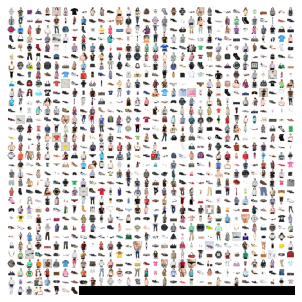

In [15]:
docs.plot_image_sprites() # Preview the images

## Apply preprocessing

In [16]:
from docarray import Document

# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [17]:
# apply en masse
docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 1000                                  
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       1000             False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   1000             False            
  uri         ('str',)       1000             False

## Embed images

In [8]:
!pip install torchvision -q

In [18]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu" # Change to "cpu" if you don't have GPU (it'll still run fine, just a bit slower)

In [21]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

### Load fine-tuned model if we have it

In [20]:
import os

if os.path.isfile(TUNED_MODEL_NAME):
    model.load_state_dict(torch.load(TUNED_MODEL))

NameError: name 'model' is not defined

In [19]:
docs.embed(model, device=device)

NameError: name 'model' is not defined

### Visualize embeddings

In [ ]:
docs.plot_embeddings(image_sprites=True, image_source="uri")

/mnt/data/work/notebooks/docarray/env/lib/python3.7/site-packages/docarray/array/mixins/plot.py:253: UserWarning: Showing iframe in cell, you may want to open http://127.0.0.1:33837/static/index.html?config=config.json in a new tab for better experience. Also, `localhost` may need to be changed to the IP address if your jupyter is running remotely. Click "stop" button in the toolbar to move to the next cell.
  f'Showing iframe in cell, you may want to open {url_html_path} in a new tab for better experience. '


## Create query Document

Let's just use the first image from our dataset:

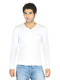

In [15]:
query_doc = Document(uri="data/20000.jpg")
query_doc.display()

In [16]:
# Throw the one Document into a DocumentArray, since that's what we're matching against
query_docs = DocumentArray([query_doc])

In [17]:
# Apply same preprocessing
query_docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 1                                     
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   1                False            
  uri         ('str',)       1                False

In [18]:
# ...and create embedding just like we did with the dataset
query_docs.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

                             Documents Summary                              
                                                                            
  Length                 1                                                  
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    1                False            
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       1                False            
  uri         ('ndarray',)   1                False

## Get matches

In [19]:
query_docs.match(docs, limit=9)

In [20]:
for doc in query_doc.matches:
    print(doc.uri)

./data/20000.jpg
./data/20183.jpg
./data/20184.jpg
./data/20340.jpg
./data/20027.jpg
./data/20958.jpg
./data/20320.jpg
./data/20204.jpg
./data/20379.jpg


## See the results

As you can see, the model is finding matches based on the input images - including the human wearing the clothes! In reality we want to match the clothes themselves, so later we'll fine-tune our model using Jina AI's [finetuner](https://finetuner.jina.ai).

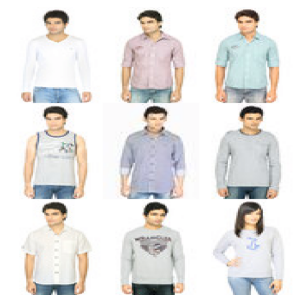

In [21]:
(DocumentArray(query_doc.matches, copy=True)
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())
    .plot_image_sprites())

In [24]:
query_doc.matches.plot_embeddings(image_sprites=True)

ValueError: Bad image tensor. Try different `image_source` or `channel_axis`

### Next steps

- [Finetune](https://finetuner.jina.ai) our model to improve matching
- Build into a real-world search engine with [Jina](https://github.com/jina-ai/jina) (example [here](http://examples.jina.ai/fashion))